# Práctica 05: Propagación

In [2]:
%matplotlib notebook
import numpy as np  # cálculo numérico
import matplotlib.pyplot as plt  # gráficos
import matplotlib.transforms as mtransforms
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy.special as sc
import sympy as sp
from sympy.vector import CoordSys3D # para trabajar con vectores
N = CoordSys3D('N') # Sistema de coordenadas de referencia 
# (los vectores unitarios para x,y,z son N.i,N.j,N.k)
from sympy import fourier_transform
import scipy.signal as scs
π=np.pi       # número pi

## Relación señal a ruido en un enlace

Una onda de $E_i = 19\,\rm{μV/m}$ y frecuencia $2\,\rm{GHz}$, incide
sobre una antena de directividad $D =\,20 \rm{dB}$ y eficiencia $η_l =
0,7$. La temperatura de ruido de antena es $T_a =\,200 \rm{K}$, la
temperatura ambiente $T_{amb} =\,300 \rm{K}$ y el ancho de banda
$B=\,10\rm{MHz}$. La antena lleva incorporado un preamplificador de
ganancia $G_p =\,20 \rm{dB}$ y factor de ruido $F_p =\,6 \rm{dB}$, al
que sigue una línea de transmisión con pérdidas de $L=\,3\rm{dB}$ y un
amplificador de ganancia $G_a =\, 23\rm{dB}$ y factor de ruido $F_a
=\,10 \rm{dB}$.
- Se obtiene a continuación la potencia de la señal y del ruido, y la
  relación señal-ruido a la salida del amplificador.
- La señal vendrá dada por la ecuación de transmisión y la ganancia total
  en la cadena de recepción

In [3]:
def respuesta_01():
    π=np.pi       # número pi
    f=2*1e9       # frecuencia [Hz]
    λ=3*1e8/f     # longitud de onda [m]  
    Ei=19*1e-6    # campo incidente [V/m]
    η0=120*π      # impedancia intrínseca del vacío [ohm]  
    D=10**(20/10) # directividad de la antena receptora [u.n.]
    Ta=200        # temperatura de antena [K]
    T0=290        # temperatura de  referencia [K]
    Tamb=300      # temperatura ambiente [K]
    B=10*1e6      # ancho de banda [Hz]
    ηl=0.7        # eficiencia de la antena [%]
    Gp=10**(20/10)# ganancia del preamplificador [u.n.]
    Fp=10**(6/10) # figura de ruido del preamplificador [u.n.]
    Ga=10**(23/10)# ganancia del amplificador [u.n.]
    Fa=10**(10/10)# figura de ruido del amplificador [u.n.]
    L=10**(3/10)  # pérdidas de la línea de transmisión [u.n.]
    k=1.38*1e-23  # constante de Boltzmann [J/K]         

    # Edita a partir de aquí

    from numpy import abs, log10
    pi = π
    # Definimos las pérdidas en la línea de transmisión de la siguiente manera:
    ηLT = 1/L
    # Potencia de señal al final de la cadena de recepción
    
    # Calculamos el área efectiva
    Aef= D*λ**2 / (4*π)
    
    # Tenemos que multiplicar la potencia de la señal(el campo eléctrico al cuadrado partido la impedancia) 
    # por el área efectiva, la ganancia del preamplificador y del amplificador 
    # por donde pasa la señal, las pérdidas de la línea, y la eficiencia
    Ps= (Ei**2 / η0) * Aef * Gp * Ga * ηLT * ηl
    
    # Ruido en bornes de la antena
    # Según la fórmula (5.2.6) del temario de la asignatura
    Na= k*Ta*B*ηl + k*Tamb*B*(1-ηl)
    
    # Ruido a la salida del preamplificador
    # Empleamos (5.2.11)
    Np= (Na + k*T0*(Fp-1)*B)*Gp
    
    # Ruido a la salida de la línea
    # Nos fijamos en (5.2.7): Incorporamos las pérdidas en la línea de transmisión al ruido en la salida del
    # preamplificador 
    NL= Np*ηLT + k*Tamb*B*(1-ηLT)
    
    # Ruido a la salida del amplificador
    # Empleamos (5.2.11)
    N= (NL + k*T0*(Fa-1)*B)*Ga
    
    # Pasamos todo a dBm
    Ps_dBm=10*log10(Ps/10**-3)
    Na_dBm=10*log10(Na/10**-3)
    Np_dBm=10*log10(Np/10**-3)
    NL_dBm=10*log10(NL/10**-3)
    N_dBm=10*log10(N/10**-3)
    
        
    return Ps_dBm,N_dBm,NL_dBm,Np_dBm,Na_dBm

respuesta_01()

(-59.20753222732578,
 -57.995843858311204,
 -81.19717737410129,
 -78.20900864447367,
 -104.9839307758117)

## Modelo de tierra plana

Se desea establecer un enlace radioeléctrico sobre una tierra llana
conductora con $ε_r$ = 10. La longitud del enlace es de 10 km, siendo
las alturas de antena transmisora y receptora de 365 y 5 m
respectivamente, ambas sobre el suelo. La frecuencia de trabajo es de
250 MHz y el transmisor entrega 100 W a una antena con polarización
circular a izquierdas y ganancia de 10 dBi, considerándose
despreciables las pérdidas.  Se supone que el mecanismo de propagación
dominante es el de reflexión sobre el suelo (no tenemos en cuenta la
onda de superficie). Se puede suponer que la ganancia de las antenas
es la misma en la dirección del rayo directo y del reflejado. El rayo
reflejado tiene un ángulo de elevación desde la horizontal denominado
$\psi$. Los coeficientes de reflexión para polarización horizontal y
vertical se pueden aproximar por $R_h=-1$,
$R_v=-\frac{1-\psi\sqrt{ε_r}}{1+\psi\sqrt{ε_r}}$
- Obténgase la potencia disponible (en dBm) en el extremo receptor si
 la antena receptora tiene una ganancia de 10 dBi y polarización
 circular a izquierdas

In [4]:
def respuesta_02():
    π=np.pi     # número pi
    ht=365      # altura del trasmisor [m]
    hr=5        # altura del receptor [m]
    Pt=100      # potencia del trasmisor [W]
    Gt=10       # ganancia del transmisor [u.n.]
    Gr=10       # ganancia del receptor [u.n.]
    f=250*1e6   # frecuencia en [Hz]
    λ=3*1e8/f   # longitud de onda [m]
    d=10000     # distancia en [m]
    εr=10       # permitividad relativa
    Rh=-1       # coeficiente de reflexión horizontal
        
    # Edita a partir de aquí
    
    from numpy import abs, log10, sqrt, array, arctan, pi, exp
    π = pi
    
    # ángulo de elevación
    # Conociendo las alturas y la distancia d, podemos hallar el ángulo. Para ello, se plantean la tangente de ψ respecto a
    # la altura de ht y luego de hr, y finalmente igualando se halla la distancia al receptor (x) y al transmisor (d-x)
    # Despejando, se calcula ψ a partir de su arcotangente
    ψ= arctan((ht + hr)/d)
    
    # coeficiente de reflexión vertical
    # Utilizamos la aproximación que viene descrita en el enunciado
    Rv= -(1-ψ*sqrt(εr)) / (1+ψ*sqrt(εr))

    ### Pérdidas incluyendo desadaptación de polarización y excluyendo AEL (Atenuación en el espacio libre)
    k = 2*π/λ
  
    
    # Calculamos el coeficiente de reflexión vertical
    Rv = - (1 - ψ*sqrt(εr)) /(1 + ψ*sqrt(εr))
    Δ = 4*π*ht*hr / (λ*d)
    r1 = 1 + Rv*exp(-1j*Δ)
    r2 = 1 + Rh*exp(-1j*Δ)
    
    er = array([1, 1j])/sqrt(2)*array([r1, r2])
    et = array([1, -1j])/sqrt(2)
    
    
    # Calculamos el coeficiente de pérdidas por desadaptación de polarización
    C_pol = abs(et @ er) **2   # Producto escalar
    

    L_dB= 10*log10(1/C_pol)
    
    # Atenuación por progagación en espacio libre
    # Empleamos (5.3.16) de los apuntes
    AEL_dB= 32.45 + 20*log10(f/1e6) + 20*log10(d/1e3)
        
    # Potencia recibida en dBm
    Pr_dBm= 10*log10(Pt)+30+10*log10(Gt)+10*log10(Gr) - AEL_dB - L_dB 
    
    return ψ,Rv,AEL_dB,L_dB,Pr_dBm

respuesta_02()

(0.03698312952191079,
 -0.7905889654649478,
 100.40880017344075,
 -3.8007787284313905,
 -26.608021445009364)

## Modelo de tierra plana con onda de superficie

Calcúlese la potencia recibida (en dBm) en un enlace radioeléctrico
situado sobre un terreno liso y húmedo. Los datos del enlace son:
- PIRE = 20 W
- Longitud de enlace 30 km
- Frecuencia: 100 MHz
- Alturas sobre el suelo del transmisor y receptor: 15 y 2 m
  respectivamente
- Antena transmisora yagi vertical de 3 directores y ganancia 6,8 dBd
- Antena receptora dipolo vertical
- Perdidas adicionales: 0 dB.

In [5]:
def respuesta_03():   
    PIRE=20    # Potencia isotrópica radiada equivalente [W]
    d_km=30    # distancia [km]
    f_MHz=100  # frecuencia [MHz]
    ht=15      # altura del trasmisor [m]
    hr=2       # altura del receptor [m]

    # Editar a partir de aquí
    from numpy import log10,sqrt, pi
    pi = π
    
    # Atenuación por propagación en espacio libre
    AEL_dB= 32.45 + 20*log10(f_MHz) + 20*log10(d_km)
      
    # Alturas ficticias para incluir onda superficie
    
    # Con la tabla (5.1) de los apuntes, considerando que es suelo húmedo a la frecuencia dada, podemos escribir
    h0 = 3
    # Considerando la fórmula (5.3.20) para el efecto de la onda de superficie
    htt= sqrt(ht**2 + h0**2)
    hrr = sqrt(hr**2 + h0**2)
    
    # Pérdidas en exceso 
    # Despejamos de (5.3.17) y de (5.3.18)
    λ=3*1e8/(f_MHz*1e6)
    Lex = (4*π*htt*hrr / (λ*d_km*1000) )**-2

    Lex_dB= 10*log10(Lex)
    
    # Potencia recibida en dBm
    Pr_dBm= 10*log10(PIRE) + 30 + 10*log10(1.64) - AEL_dB - Lex_dB
    
    return AEL_dB,htt,Lex_dB,Pr_dBm

respuesta_03()  

(101.99242509439325,
 15.297058540778355,
 282.26906081117477,
 -339.10274746845124)

## Enlace punto a punto con difracción

Las integrales de Fresnel C y S se pueden calcular a partir de la función
de error:

In [6]:
z=lambda ν:np.sqrt(π)*(1-1j)*ν/2;
C=lambda ν:np.real(((1+1j)/2)*sc.erf(z(ν)))
S=lambda ν:np.imag(((1+1j)/2)*sc.erf(z(ν)))

Pero en scipy hay una función de librería para la integral de Fresnel directamente:

In [7]:
S=lambda nu: sc.fresnel(nu)[0]
C=lambda nu: sc.fresnel(nu)[1]

<IPython.core.display.Javascript object>


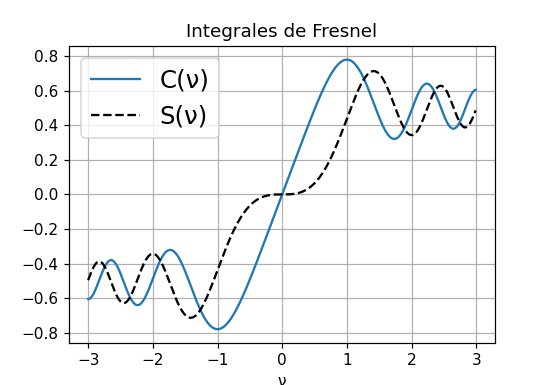

In [8]:
from ftrlearn05 import muestra_integrales_de_fresnel    
muestra_integrales_de_fresnel()

<IPython.core.display.Javascript object>


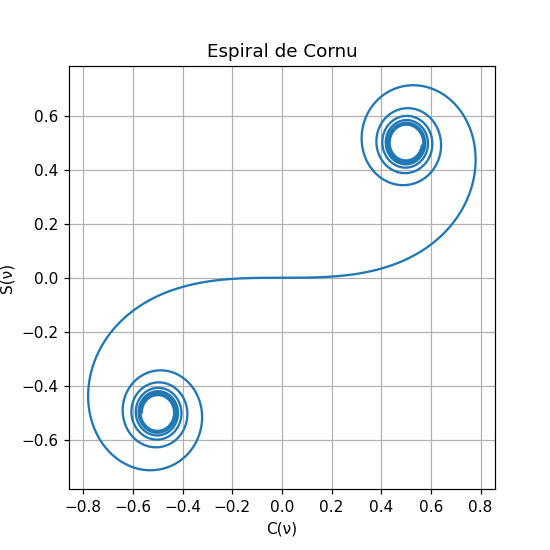

In [9]:
from ftrlearn05 import muestra_espiral_de_cornu    
muestra_espiral_de_cornu()

Estas integrales se utilizan para calcular la atenuación por difracción:

In [10]:
F=lambda ν: 0.5*(1+1j)*((0.5-C(ν))-1j*(0.5-S(ν)))
# Atenuación por difracción en arista afilada
L_arista=lambda ν: -20*np.log10(np.abs(F(ν)))

<IPython.core.display.Javascript object>


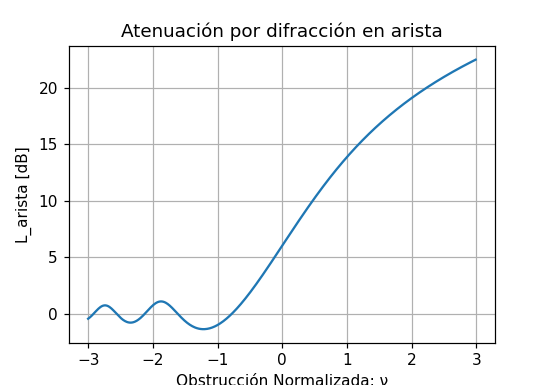

In [11]:
from ftrlearn05 import muestra_atenuación_en_arista    
muestra_atenuación_en_arista()

<img src="figuras/enlace_punto_a_punto.svg" alt="Enlace punto a punto"  width="1000px">

Un enlace radioeléctrico está constituido por dos antenas de alturas
sobre el suelo:
- ht = 50 m 
- hr = 20 m. 
- La distancia es de 30 km. 
- A 10 km. del transmisor hay un obstáculo de altura h = 40 m sobre el
  suelo, siendo el único obstáculo notable del trayecto.
- La frecuencia de trabajo es f = 300 MHz.
Calcular:
- El valor de despejamiento para k = 4/3 y k = 2/3
- Pérdida básica de propagación para los dos valores de factor k
  anteriores

In [12]:
def respuesta_04():
    d_1=10e3 # distancia Tx-obstáculo [m]
    d_2=20e3 # distancia obstáculo-RX [m]
    R_T=6370e3 # radio de la Tierra [m]
    d=d_1+d_2 # distancia del enlace [m]
    k_e1=4/3 # factor de Tierra ficticia 1 
    k_e2=2/3 # factor de Tierra ficticia 2
    h_t=50   # altura del transmisor [m]
    h_r=20   # altura del receptor [m]
    h_obs=40  # altura del obstáculo [m]
    f=300e6   # frecuencia de trabajo [Hz]
    c=3e8 # velocidad de la luz [m/s]
    λ=c/f # longitud de onda [m]
    
    # Edita a partir de aquí

    # Ecuación del rayo 
    h_rayo=lambda x: 0
    # Protuberancia de Tierra ficticia
    b_E1=lambda x: 0
    
    # Radio de la primera zona de Fresnel
    R_1=0
    # Despejamientos para dos valores de k_e
    c_r1,c_r2=[0,0]
    # Obstáculos normalizados para los dos k_e
    ν_1,ν_2=[0,0]
    # Pérdidas por difracción en arista (para dos k_e)
    L1,L2=[0,0]
    
    # Atenuación en espacio libre 
    AEL=0
    
    # Pérdidas básicas de propagación (para 2 k_e)
    Lb1,Lb2=[0,0]
     
    return h_rayo,b_E1,c_r1,ν_1,R_1,AEL,Lb1,Lb2

respuesta_04()

(<function __main__.respuesta_04.<locals>.<lambda>(x)>,
 <function __main__.respuesta_04.<locals>.<lambda>(x)>,
 0,
 0,
 0,
 0,
 0,
 0)

## Desplazamiento Doppler

<img src="figuras/doppler_basico.svg" alt="Doppler"  width="1000px">

Tenemos un enlace entre una estación base fija (EB) y un receptor
móvil (RM). Suponemos que no existe más que el rayo
directo. Consideramos un segmento pequeño de la trayectoria del móvil,
por lo que la señal recibida puede considerarse de amplitud
constante. Sin embargo la fase variará rápidamente. Sabemos que el
efecto Doppler producirá un desplazamiento en frecuencia que queremos
mostrar.

Como vemos en la figura la EB está situada sobre el plano xy, en
concreto en un punto del eje $x$ a una distancia $d$ del origen, en el
que se encuentra el móvil en el instante inicial. Si el móvil se mueve
hacia delante con velocidad $V$ los puntos de muestreo espaciales serán:
$$
\begin{align}
x[0]&=0 \nonumber\\ 
x[1]&=Δx \nonumber\\ 
x[2]&=2Δx \nonumber
\end{align}
$$
y los puntos de muestreo temporal correspondientes serán:
$$
\begin{align}
t[0]&=0 \nonumber\\ 
t[1]&=\frac{Δx}{V} \nonumber\\ 
t[2]&=\frac{2Δx}{V} \nonumber
\end{align}
$$
La distancia entre la EB y el RM para cada punto de muestreo será:
$$
\begin{align}
d[0]&=d \nonumber\\ 
d[1]&=d-Δx \nonumber\\ 
d[2]&=d-2Δx \nonumber
\end{align}
$$
Asumimos el rayo directo horizontal para simplificar los
cálculos. La amplitud no varía en el entorno local, por lo que
usaremos amplitud normalizada unidad. En cada punto de muestreo
únicamente varía la fase, que en el origen asumimos que vale 0. Por tanto
la señal paso bajo compleja equivalente en cada punto de muestreo es:
$$
\begin{align}
r[0]&=e^{-jkd[0]} \nonumber\\ 
r[1]&=e^{-jkd[1]} \nonumber\\ 
r[2]&=e^{-jkd[2]} \nonumber
\end{align}
$$
- Calcular el espectro de la señal normalizado respecto a su valor máximo 

Para un resumen sobre el uso de la fft para representar señales:
- https://numpy.org/doc/stable/reference/routines.fft.html
- https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
- A continuación ejemplo en python

<IPython.core.display.Javascript object>


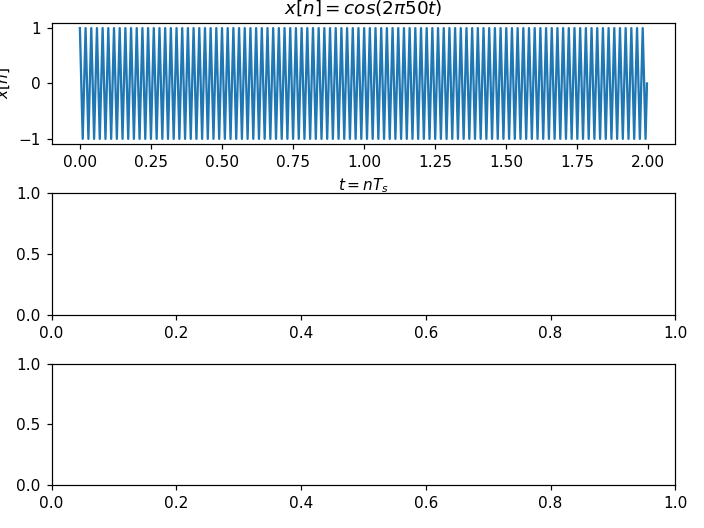

TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

In [13]:
from ftrlearn05 import muestra_ejemplo_fft
muestra_ejemplo_fft() #se puede ver el código en el fichero ftrlearn05.py

In [ ]:
def respuesta_05():
    
    π=np.pi       # número pi
    f=2000*1e6    # frecuencia portadora [Hz]
    F=16          # tasa de muestreo espacial: fracción de lambda
    V=10          # velocidad del M  [m/s] 
    NFFT=128      # número de puntos de la FFT
    Nmuestras=100 # número de muestras

    # parámetros geométricos --------------------------
    dEB=1000      # distancia desde la estación base al origen
    φ = 0         # acimut de la estación base 

    # coordenadas del M en función de φ-----------------
    EBx=dEB*np.cos(np.deg2rad(φ))  # coordenada x de la EB
    EBy=dEB*np.sin(np.deg2rad(φ))  # coordenada y de la EB
    
    # parámetros derivados ----------------------------
    c=3e8              # velocidad luz en el vacío [m/s]
    λ=c/f              # longitud de onda [m]
    Δx=λ/F             # espacio entre muestras [m] 
    ts=Δx/V            # tiempo entre muestras [s]
    fs=1/ts            # frecuencia de muestreo [Hz]
    k=2*π/λ            # número de ondas

    eje_temporal=ts*np.arange(0,Nmuestras) #  eje de tiempo transcurrido [s]
    eje_distancia=Δx*np.arange(0,Nmuestras)  #  eje de distancia recorrida [n]

    # Edita a partir de aquí
    
    # distancia recorrida por el rayo directo ------------------------------
    distEBRM=0

    # envolvente compleja de la señal: amplitud unidad y fase-----------------
    r=np.exp(-1j*0)

    # espectro de la envolvente compleja -----------------------------------
    from numpy.fft import fft,ifft,fftshift
    
    espectro_r=0
    eje_frecuencia=0
    
    return eje_frecuencia,espectro_r

from ftrlearn05 import muestra_desplazamiento_doppler
muestra_desplazamiento_doppler(respuesta_05()[0],respuesta_05()[1])

## Desplazamiento Doppler con señal directa y reflejada

Ahora tenemos la estación base EB en x=-1000m. En x=1000m tenemos un
dispersor que refleja la señal con coeficiente de reflexión -1 hacia
el receptor móvil RM, que se encuentra en x=0 y y se mueve con
velocidad V=10 en el sentido de las x crecientes. Considerar una
atenuación de la amplitud proporcional al inverso de la
distancia. Calcular:
- El espectro normalizado de la envolvente compleja con su eje de
  frecuencias
- Envolvente compleja con su eje temporal

In [ ]:
def respuesta_06():
    
    π=np.pi       # número pi
    f=2000*1e6    # frecuencia portadora [Hz]
    F=16          # tasa de muestreo espacial: fracción de lambda
    V=10          # velocidad del RM  [m/s] 
    NFFT=128      # número de puntos de la FFT
    Nmuestras=100 # número de muestras

    # parámetros geométricos --------------------------
    EBx= -1000      # coordenada x de la EB
    EBy= 0          # coordenada y de la EB
    RM0 = 0         # coordenada inicial del RM en x
    RMy = 0         # coordenada y del RM

    φ=0             # grados
    dD1=1000        # distancia en m al origen del dispersor
    # coordenadas del dispersor 1 en función de su φ ---
    D1x=dD1*np.cos(np.deg2rad(φ))  # coordenada x del dispersor 1
    D1y=dD1*np.sin(np.deg2rad(φ))  # coordenada y del dispersor 1
    
    # parámetros derivados ----------------------------
    c=3e8              # velocidad luz en el vacío [m/s]
    λ=c/f              # longitud de onda [m]
    Δx=λ/F             # espacio entre muestras [m] 
    ts=Δx/V            # tiempo entre muestras [s]
    fs=1/ts            # frecuencia de muestreo [Hz]
    k=2*π/λ       # número de ondas

    eje_temporal=ts*np.arange(0,Nmuestras) #  eje de tiempo transcurrido [s]
    eje_distancia=Δx*np.arange(0,Nmuestras)  #  eje de distancia recorrida [n]

    # Edita a partir de aquí
    
    # distancia recorrida por el rayo directo ------------------------------
    distEBRM=1
    # distancia recorrida por el rayo reflejado
    distEBD1RM=1
    
    # envolvente compleja de la señal: amplitud 1/r y fase variable --------------
    rayo1=np.exp(-1j*0)/distEBRM
    rayo2=np.exp(-1j*0)/distEBD1RM
    r=0

    # espectro de la envolvente compleja -----------------------------------
    from numpy.fft import fft,ifft,fftshift
    
    espectro_r=0
    eje_frecuencia=0
    
    return eje_frecuencia,espectro_r,eje_temporal,r

from ftrlearn05 import muestra_desplazamiento_doppler, muestra_envolvente    
muestra_desplazamiento_doppler(respuesta_06()[0],respuesta_06()[1])
muestra_envolvente(respuesta_06()[2],respuesta_06()[3])

## Distribución Rayleigh. Propiedades

La distribución Rayleigh aparecerá en múltiples ocasiones
en propagación. Repasemos sus propiedades.
$$f(\sigma,x)=\frac{x}{\sigma^2} e^{-\frac{x^2}{2\sigma^2}}$$

<IPython.core.display.Javascript object>


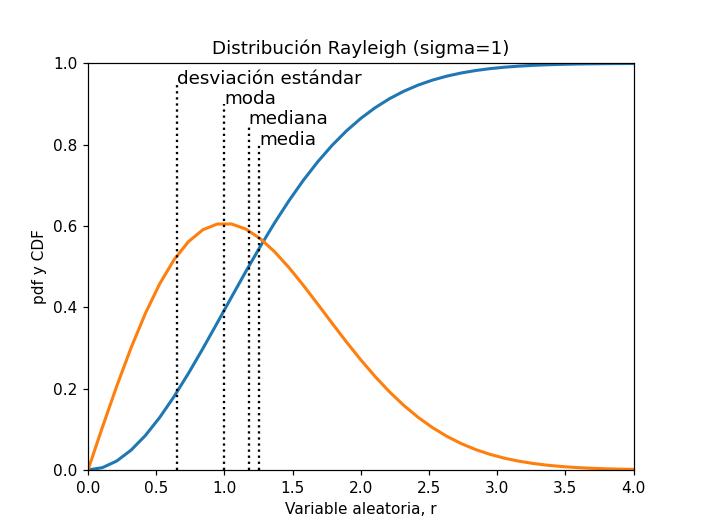

In [16]:
def respuesta_07():
    ''' Rellena el cuerpo de las funciones lambda
    donde σ es el parámetro de escala de la
    distribución Rayleigh. La siguiente celda
    muestra tu respuesta para que puedas visualizarla'''
    
    from numpy import log, sqrt, pi
    π = pi
    modalvalue=lambda σ: σ
    standarddeviation=lambda σ: σ*sqrt(2 - (π/2))
    meanvalue=lambda σ: σ*sqrt(π/2)
    medianvalue= lambda σ: σ*sqrt(2*log(2))

    return([modalvalue,standarddeviation,meanvalue,medianvalue])

from ftrlearn05 import muestra_respuesta_07
muestra_respuesta_07(respuesta_07,sigma=1) # puedes modificar el valor de sigma

## Análisis estadístico de una serie temporal

A continuación se cargan los datos de una serie temporal de
medidas tomadas por nuestro receptor en dBm y se muestran
por pantalla

<IPython.core.display.Javascript object>


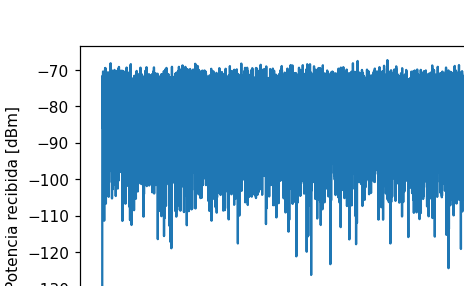

In [15]:
from ftrlearn05 import muestra_serie_temporal
muestra_serie_temporal()

Queremos comparar la serie con una distribución Rayleigh de moda
unidad.  Dada la serie temporal anterior, pasamos la potencia a mW,
luego a W, finalmente a voltios rms sobre una resistencia de 50
ohmios. Normalizamos dicho voltaje con la moda que tendría si tuviera
una distribución Rayleigh (pista: en la Rayleigh hay una relación
entre la moda y la media)

<IPython.core.display.Javascript object>


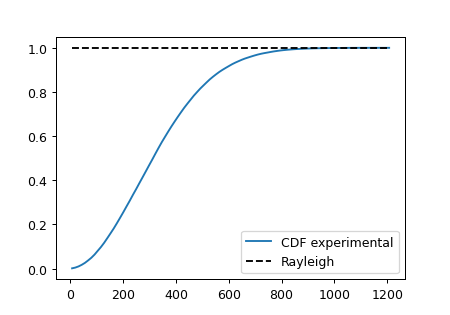

In [146]:
def respuesta_08():
    
    serie1=np.load('serie1.npy')
    eje_temporal=serie1[:,0]
    P=serie1[:,1]
    
    # Edita a partir de aquí
    from numpy import pi, log, sqrt
    # Según el enunciado, la moda = unidad
    μ = 1
    
    # potencia en [mW]
    p=10**(P/10)
    
    # potencia en [W]
    p_W=p*(10**-3)
    
    # tensión [V] rms
    # Por el enunciado, la resistencia es de 50ohms
    v=sqrt(p_W*50)
    
    # estimación de la moda
    sigma= μ / sqrt(π/2) 
    
    # tensión normalizada con la moda
    vnorm= v/sigma *10e6 # esto es una serie
    
    
    # histograma de las tensiones con 100 bins
    '''
    bin_centers=0
    y=0
    '''    
    hist, bin_edges = np.histogram(vnorm, bins=100)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    y = np.cumsum(hist * np.diff(bin_edges))
    y /= y[-1]  # Normalización
    
    return bin_centers,y

from ftrlearn05 import muestra_comparacion_con_rayleigh    
muestra_comparacion_con_rayleigh(respuesta_08()[0],respuesta_08()[1])

In [145]:
respuesta_08()

(array([6.27509, 18.4076, 30.54, 42.6725, 54.805, 66.9374, 79.0699,
        91.2024, 103.335, 115.467, 127.6, 139.732, 151.865, 163.997,
        176.13, 188.262, 200.395, 212.527, 224.659, 236.792, 248.924,
        261.057, 273.189, 285.322, 297.454, 309.587, 321.719, 333.852,
        345.984, 358.117, 370.249, 382.382, 394.514, 406.646, 418.779,
        430.911, 443.044, 455.176, 467.309, 479.441, 491.574, 503.706,
        515.839, 527.971, 540.104, 552.236, 564.369, 576.501, 588.633,
        600.766, 612.898, 625.031, 637.163, 649.296, 661.428, 673.561,
        685.693, 697.826, 709.958, 722.091, 734.223, 746.356, 758.488,
        770.62, 782.753, 794.885, 807.018, 819.15, 831.283, 843.415,
        855.548, 867.68, 879.813, 891.945, 904.078, 916.21, 928.342,
        940.475, 952.607, 964.74, 976.872, 989.005, 1001.14, 1013.27,
        1025.4, 1037.53, 1049.67, 1061.8, 1073.93, 1086.06, 1098.2,
        1110.33, 1122.46, 1134.59, 1146.73, 1158.86, 1170.99, 1183.12,
        1195.26, 120

## Ensombrecimiento (shadowing)

Queremos que una célula tenga un radio de cobertura d=1 km. La
potencia del transmisor son Pt = 10dBm.  Determinar el % de
emplazamientos en los que se garantiza una recepción correcta de la
señal. La sensibilidad del receptor Pu = 90dBm. Aplíquese el modelo de
Tierra plana, con ganancias en las antenas Gt = Gr = 3dB. Altura de la
estación base de ht=50 metros y altura del móvil hr=1 metro. El
desvanecimiento lento se caracteriza con una distribución log-normal
con desviación típica $\sigma$ = 10dB

In [38]:
def respuesta_09():
    d=1000      # radio zona cobertura [m]
    Pt_dBm=10   # potencia del tx [dBm]
    Pu_dBm=-90  # potencia umbral del rx [dBm]
    Gt_dB=3     # ganancia del tx [dB]
    Gr_dB=3     # ganancia del rx [dB]
    ht=50       # altura del tx [m]
    hr=1        # altura del rx [m]
    sigma_dB=10 # desviación típica [dB]
 
    # Edita a partir de aquí
    
    '''
    P=0
    prob=0
    '''
    
    # imports
    from scipy import stats
    from numpy import log10, pi, log
    c = 3 * 10**8  # Speed of light in m/s
    f = 0.9 * 10**9  # Assumed frequency in Hz (900 MHz)
    f_MHz = 900
    
    
    #modelo okumura hata
    R = 1
    A = 69.55 + 26.16*log10(f_MHz)  - 13.82*log10(ht)
    B = 44.9 - 6.55*log10(ht)
    E = 3.2*(log10(11.75*hr))**2 - 4.97
    
    Lp_dB = A + B*log10(R) - D

    # Calcular la potencia recibida
    Pr_dBm = Pt_dBm + Gt_dB + Gr_dB - Lp_dB
    P = Pr_dBm

    # Calcular la probabilidad de que la potencia recibida sea mayor que la sensibilidad del receptor
    # Considerando el ensombrecimiento como una variación log-normal
    # Convertir todo a una distribución normal estándar
    z = (Pu_dBm - Pr_dBm) / sigma_dB
    prob = stats.norm.cdf(z)
    
    
    return P,prob

respuesta_09()

NameError: name 'D' is not defined

## Ensombrecimiento correlado

Vamos a asumir por el momento que nos estamos moviendo sin cambiar la
distancia respecto a la estación base, de modo que la señal viene
caracterizada por su media M y su desviación típica σ, que son
conocidas. Queremos generar la distribución log-normal típica de los
ensombrecimientos (shadowing). Pero además queremos implementar la
autocorrelación observada en la realidad, que viene caracterizada por
lo que se conoce como distancia de correlación $L_{corr}$, que depende
del tamaño típico de los obstáculos en la zona de recepción. Para
lograr nuestro objetivo vamos a emplear en primer lugar un filtro
autoregresivo como el mostrado en la figura. Primero generamos
$N_{samples}$ muestras independientes con distribución normal de media
cero y varianza unidad. Seleccionamos la distancia de muestreo
espacial $d_s$ equivalente a un periodo de muestreo temporal $T$, con
$L_{corr}>d_s$. Las muestras son retrasadas un periodo de muestreo $T$
y son multiplicadas por el coeficiente $a=e^{-d_s/L_{corr}}$ donde
$d_s=vT$ siendo $v$ la velocidad de desplazamiento. Luego se suma a la
muestra nueva. A la salida del filtro se multiplica por
$\sigma\sqrt{1-a^2}$ para obtener la desviación estándar
requerida. Finalmente aunque no venga en la figura desplazamos la
señal para que tenga la media M requerida sumando dicha media. La
respuesta debe devolver las muestras filtradas en [dBm] y las muestras de
normal estándar de media nula y varianza unidad generadas. Para poder
implementar el filtro se recomienda obtener su transformada z primero.
Para implementarlo en python emplear scipy.signal.lfilter 
![Filtro fir](figuras/fir.png)
-

In [ ]:
def respuesta_10():
    
    Lcorr=10.0      # Distancia de correlación en metros
    M=-80.0         # Valor medio de potencia recibia en [dBm]
    σ=5.0           # Desviación estándar en [dB] (log-normal)
    ds=1.0          # Distancia de muestreo [m]   
    Nsamples=200    # Número de muestras a generar  
    # Edita a partir de aquí

    muestras_normales=np.zeros(Nsamples)
    correlated_shadowing=np.zeros(Nsamples) 

    return muestras_normales,correlated_shadowing

In [ ]:
from ftrlearn05 import muestra_respuesta_10
muestra_respuesta_10(respuesta_10)

In [ ]:
from ftrlearn05 import muestra_autocorrelacion_respuesta_10
muestra_autocorrelacion_respuesta_10(respuesta_10) 